In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from keras.models import load_model, Model
from keras import backend as K
import tensorflow as tf

from utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body


/home/shreyasrbhat/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


box_confidence -- tensor of shape (19, 19, 5, 1)
boxes -- tensor of shape (19, 19, 5, 4)
box_class_probs -- tensor of shape (19, 19, 5, 80)

In [2]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.6):
    
    
    box_scores = box_confidence * box_class_probs
    box_classes = K.argmax(box_scores, axis = -1)
    box_class_scores = K.max(box_scores, axis = [-1])
    
    filtering_mask = (box_class_scores > threshold)
    
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

In [4]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 51)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 551)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 51)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

scores[2] = 18.66819
boxes[2] = [ 1.9018091 -3.9903622 -4.009363  -3.981121 ]
classes[2] = 21
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


In [20]:
def iou(box1, box2):

    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    
    
    
    iou = inter_area / union_area
    

    return iou

In [8]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold)
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    
    
    return scores, boxes, classes

In [9]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 51)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 51)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 51)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    init=tf.global_variables_initializer()
    test_b.run(init)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

    

scores[2] = 7.2168345
boxes[2] = [  1.3835918  -2.2073252   2.5128307 -10.085559 ]
classes[2] = -5.1675873
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [10]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=5, score_threshold=.6, iou_threshold=.5):
    
    box_xy, box_wh,  box_confidence, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    boxes = scale_boxes(boxes, image_shape)

    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    return scores, boxes, classes

In [11]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 51),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 51),
                    tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 51),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 51))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    init=tf.global_variables_initializer()
    test_b.run(init)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))


scores[2] = 155.1541
boxes[2] = [   109.86103  -5404.5874     329.5831  -16213.762  ]
classes[2] = 16
scores.shape = (5,)
boxes.shape = (5, 4)
classes.shape = (5,)


In [16]:
sess = K.get_session()

In [19]:
class_names = read_classes("model_data/pascal_classes.txt")
anchors = read_anchors("model_data/yolo_tiny_anchors.txt")
image_shape = (375., 500.)

In [20]:
yolo_model = load_model("model_data/yolo_tiny.h5")

/home/shreyasrbhat/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [21]:
yolo_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 416, 416, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 416, 416, 16)      432       
_________________________________________________________________
batch_normalization_1 (Batch (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 416, 416, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 208, 208, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 208, 208, 32)      4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 208, 208, 32)      128       
__________

In [24]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [25]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [32]:
def predict(sess, image_file):
   

    image, image_data = preprocess_image(image_file, model_image_size = (416, 416))


    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})
    
    with open("output.txt", "w+") as file:
            file.write("%f" % np.mean(out_scores))
    
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))

    colors = generate_colors(class_names)
    
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    
    image.save(os.path.join("out", image_file), quality=90)
    
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Found 2 boxes for men.JPEG
person 0.73 (32, 57) (179, 217)
person 0.84 (218, 26) (337, 286)


/home/shreyasrbhat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


(array([0.8387335 , 0.72645026], dtype=float32),
 array([[ 25.513239, 218.34245 , 285.71967 , 427.92056 ],
        [ 57.465282,  32.01086 , 217.19899 , 179.42023 ]], dtype=float32),
 array([14, 14]))

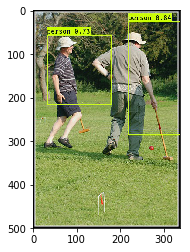

In [33]:
predict(sess, "men.JPEG")

In [43]:
from PIL import Image

In [44]:
416 * 416

173056

In [45]:
img2 = Image.open('men.JPEG')

In [46]:
img2.size

(337, 500)